In [1]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyprojec

In [2]:
import os
import torch
import random
import numpy as np
from PIL import Image
from glob import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
import albumentations as A
import albumentations.pytorch.transforms as T
from super_gradients.training import dataloaders,models,training_hyperparams,Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import training_hyperparams

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-11-05 17:25:34] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-11-05 17:25:34] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-05 17:25:46] INFO - utils.py - NumExpr defaulting to 4 threads.
[2023-11-05 17:25:48] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-05 17:25:48] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-05 17:25:48] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-05 17:25:48] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-05 17:25:48] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx required but not found
[2023-11-05 17:25:48] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2023-11-05 17:25:48] WARNING - env_sanity_check.py - Failed to verify installed packages: omegaconf required but not found
[2023-11-05 17:25:48] WARNING - env_sanity_check.py - Failed to verify install

### Set Reproducibility

In [3]:
os.environ["PYTHONHASHSEED"] = str(1234)
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
data_dir = '/kaggle/input/easyportrait'
batch_size = 32

### Data Set & Loader

In [5]:
class EasyPortraitDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform, manual_test=False):
        self.images = sorted(glob(os.path.join(images_dir, '*')))
        self.masks = sorted(glob(os.path.join(masks_dir, '*')))
        self.transform = transform
        # Manual test is defined for individual inference purpose
        self.manual_test_transform = A.Compose([A.Resize(512, 512)]) if manual_test else None
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask_path = self.masks[idx]
        mask = cv2.imread(mask_path, 0)
        if self.transform:
            if self.manual_test_transform:
                test_res = self.manual_test_transform(image=image)
                test_image = test_res['image']
                result = self.transform(image=image, mask=mask)
                image, mask = result['image'], result['mask'].type(torch.LongTensor)
                return image, mask, test_image
            result = self.transform(image=image, mask=mask)
            image, mask = result['image'], result['mask'].type(torch.LongTensor)
        return image, mask
    
# Data Transform
train_transform = A.Compose([
    A.HueSaturationValue(p=0.5),
    A.Resize(512,512),
    A.Normalize(),
    T.ToTensorV2(),
])
test_transform = A.Compose([
    A.Resize(512,512),
    A.Normalize(),
    T.ToTensorV2(),
])
# Import Data
train_dataset = EasyPortraitDataset(os.path.join(data_dir, 'images/train'), os.path.join(data_dir, 'annotations/train'),train_transform)
valid_dataset = EasyPortraitDataset(os.path.join(data_dir, 'images/val'), os.path.join(data_dir, 'annotations/val'),test_transform)
test_dataset = EasyPortraitDataset(os.path.join(data_dir, 'images/test'), os.path.join(data_dir, 'annotations/test'),test_transform)

# Data Loader
train_dataloader = dataloaders.get(dataset=train_dataset, dataloader_params={"num_workers": 2, "batch_size": batch_size, "shuffle": True, "worker_init_fn": seed_worker})
valid_dataloader = dataloaders.get(dataset=valid_dataset, dataloader_params={"num_workers": 2, "batch_size": batch_size, "shuffle": False, "worker_init_fn": seed_worker})
test_dataloader = dataloaders.get(dataset=test_dataset, dataloader_params={"num_workers": 2, "batch_size": batch_size, "shuffle": False, "worker_init_fn": seed_worker})


### Visualize Data

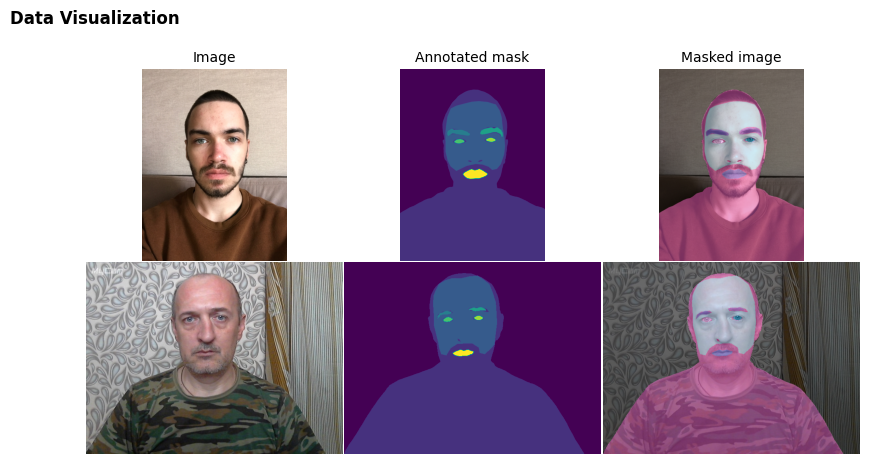

In [6]:
def visualize_seg_mask(data_sample, main_title, row_labels=None):
    # Reference: https://www.kaggle.com/code/gofixyourself/usage-example-with-pytorch-lightning
    DATASET_COLORS = [[0, 0, 0], [223, 87, 188], [160, 221, 255],[130, 106, 237], [200, 121, 255], 
                      [255, 183, 255], [0, 144, 193], [113, 137, 255], [230, 232, 230]]
    num_samples = len(data_sample)
    fig, axes_list = plt.subplots(nrows=num_samples, ncols=3, figsize=(10, 5))
    plt.subplots_adjust(hspace = 0, wspace = 0)
    orig_img, ann_mask, masked_img = axes_list[0][0], axes_list[0][1], axes_list[0][2]
    orig_img.set_title('Image', fontsize=10)
    ann_mask.set_title('Annotated mask', fontsize=10)
    masked_img.set_title('Masked image', fontsize=10)
    for idx in range(num_samples):
        image, mask = data_sample[idx]
        color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(DATASET_COLORS):
            color_seg[mask == label, :] = color
        masked_image = np.array(image) * 0.5 + color_seg * 0.5 
        masked_image = masked_image.astype(np.uint8)
        axes_list[idx][0].imshow(image)
        axes_list[idx][1].imshow(mask)
        axes_list[idx][2].imshow(masked_image)
        if row_labels:
            axes_list[idx][0].set_ylabel(row_labels[idx])
            axes_list[idx][0].set_yticklabels([])
            axes_list[idx][0].axes.get_xaxis().set_visible(False)
        else:
            axes_list[idx][0].set_axis_off()
        axes_list[idx][1].set_axis_off()
        axes_list[idx][2].set_axis_off()
    if main_title:
        plt.suptitle(main_title,
                     x=0.05, y=1.0,
                     horizontalalignment='left',
                     fontweight='semibold',
                     fontsize='large')
    plt.show()

# We visualize training data
temp_train_ds = EasyPortraitDataset(os.path.join(data_dir, 'images/train'), os.path.join(data_dir, 'annotations/train'), None)
visualize_seg_mask([temp_train_ds[i] for i in range(2)], 'Data Visualization')

### Model 1: DDRNet

#### Train Model

In [7]:
# Define Model with Transfer Learning
model_ddr = models.get(
    model_name=Models.DDRNET_23,
    arch_params={"use_aux_heads": False},
    num_classes=9,                          
    pretrained_weights="cityscapes"         
)

# Define Train Params
train_params_ddr = {"max_epochs": 5,
                "initial_lr": 1e-4,
                "optimizer": "Adam",
                "loss": "LabelSmoothingCrossEntropyLoss",
                "metric_to_watch": "IoU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [{'IOU':{'num_classes':9}}],
                "valid_metrics_list": [{'IOU':{'num_classes':9}}],
                }

# Training Model
trainer_ddr = Trainer("easyportrait-ss-train-exp",ckpt_root_dir='/kaggle/working/')
trainer_ddr.train(model=model_ddr, training_params=train_params_ddr,
              train_loader=train_dataloader, valid_loader=valid_dataloader,)

Downloading: "https://sghub.deci.ai/models/ddrnet_23_cityscapes.pth" to /root/.cache/torch/hub/checkpoints/ddrnet_23_cityscapes.pth
100%|██████████| 358M/358M [00:13<00:00, 28.3MB/s]
[2023-11-05 17:26:09] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture ddrnet_23
[2023-11-05 17:26:09] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-11-05 17:26:13] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231105_172613_829874`
[2023-11-05 17:26:13] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874


The console stream is now moved to /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/console_Nov05_17_26_13.txt


[2023-11-05 17:26:20] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            14000      (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         438        (len(train_loader))
    - Gradient updates per epoch:   438        (len(train_loader) / batch_accumulate)

[2023-11-05 17:26:20] INFO - sg_trainer.py - Started training for 5 epochs (0/4)

Validating: 100%|██████████| 63/63 [01:32<00:00,  1.47s/it]
[2023-11-05 17:41:00] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/ckpt_best.pth
[2023-

SUMMARY OF EPOCH 0
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.204
│   └── Iou = 0.5009
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0898
    └── Iou = 0.7316



Validating epoch 1: 100%|██████████| 63/63 [01:13<00:00,  1.17s/it]
[2023-11-05 17:53:20] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/ckpt_best.pth
[2023-11-05 17:53:20] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7685274481773376


SUMMARY OF EPOCH 1
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.0724
│   │   ├── Epoch N-1      = 0.204  (↘ -0.1316)
│   │   └── Best until now = 0.204  (↘ -0.1316)
│   └── Iou = 0.7525
│       ├── Epoch N-1      = 0.5009 (↗ 0.2516)
│       └── Best until now = 0.5009 (↗ 0.2516)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0664
    │   ├── Epoch N-1      = 0.0898 (↘ -0.0235)
    │   └── Best until now = 0.0898 (↘ -0.0235)
    └── Iou = 0.7685
        ├── Epoch N-1      = 0.7316 (↗ 0.0369)
        └── Best until now = 0.7316 (↗ 0.0369)



Validating epoch 2: 100%|██████████| 63/63 [01:17<00:00,  1.22s/it]
[2023-11-05 18:06:15] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/ckpt_best.pth
[2023-11-05 18:06:15] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7833518981933594


SUMMARY OF EPOCH 2
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.0558
│   │   ├── Epoch N-1      = 0.0724 (↘ -0.0166)
│   │   └── Best until now = 0.0724 (↘ -0.0166)
│   └── Iou = 0.7767
│       ├── Epoch N-1      = 0.7525 (↗ 0.0242)
│       └── Best until now = 0.7525 (↗ 0.0242)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0561
    │   ├── Epoch N-1      = 0.0664 (↘ -0.0102)
    │   └── Best until now = 0.0664 (↘ -0.0102)
    └── Iou = 0.7834
        ├── Epoch N-1      = 0.7685 (↗ 0.0148)
        └── Best until now = 0.7685 (↗ 0.0148)



Validating epoch 3: 100%|██████████| 63/63 [01:36<00:00,  1.52s/it]
[2023-11-05 18:19:46] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/ckpt_best.pth
[2023-11-05 18:19:46] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.7979324460029602


SUMMARY OF EPOCH 3
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.0513
│   │   ├── Epoch N-1      = 0.0558 (↘ -0.0045)
│   │   └── Best until now = 0.0558 (↘ -0.0045)
│   └── Iou = 0.7873
│       ├── Epoch N-1      = 0.7767 (↗ 0.0106)
│       └── Best until now = 0.7767 (↗ 0.0106)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0546
    │   ├── Epoch N-1      = 0.0561 (↘ -0.0015)
    │   └── Best until now = 0.0561 (↘ -0.0015)
    └── Iou = 0.7979
        ├── Epoch N-1      = 0.7834 (↗ 0.0146)
        └── Best until now = 0.7834 (↗ 0.0146)



Validating epoch 4: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it]
[2023-11-05 18:32:17] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/ckpt_best.pth
[2023-11-05 18:32:17] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.803004264831543


SUMMARY OF EPOCH 4
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.0461
│   │   ├── Epoch N-1      = 0.0513 (↘ -0.0052)
│   │   └── Best until now = 0.0513 (↘ -0.0052)
│   └── Iou = 0.795
│       ├── Epoch N-1      = 0.7873 (↗ 0.0077)
│       └── Best until now = 0.7873 (↗ 0.0077)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0523
    │   ├── Epoch N-1      = 0.0546 (↘ -0.0023)
    │   └── Best until now = 0.0546 (↘ -0.0023)
    └── Iou = 0.803
        ├── Epoch N-1      = 0.7979 (↗ 0.0051)
        └── Best until now = 0.7979 (↗ 0.0051)



[2023-11-05 18:32:22] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 5: 100%|██████████| 63/63 [01:13<00:00,  1.22it/s]

#### Evaluate Model

In [8]:
best_model_ddr = models.get(
    model_name=Models.DDRNET_23,
    arch_params={"use_aux_heads": False},
    num_classes=9, 
    checkpoint_path=os.path.join(trainer_ddr.checkpoints_dir_path,'ckpt_best.pth')
)

best_model_ddr.eval()
trainer_ddr.test(model=best_model_ddr, test_loader=test_dataloader)

[2023-11-05 18:33:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_172613_829874/ckpt_best.pth checkpoint.
Testing:  99%|█████████▉| 124/125 [03:06<00:01,  1.23s/it]

{'LabelSmoothingCrossEntropyLoss': 0.05662779, 'IoU': 0.7623475790023804}

#### Individual Testing

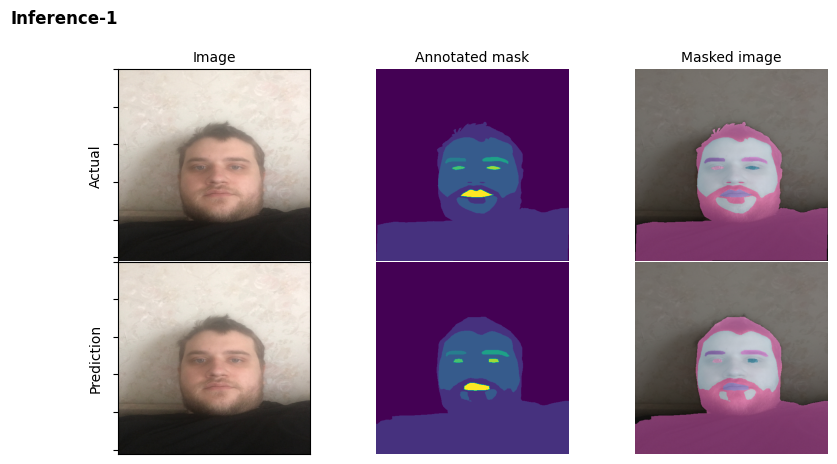

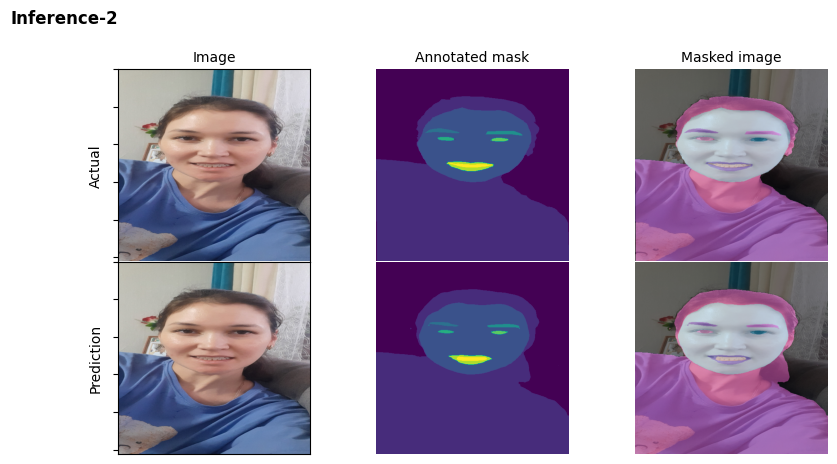

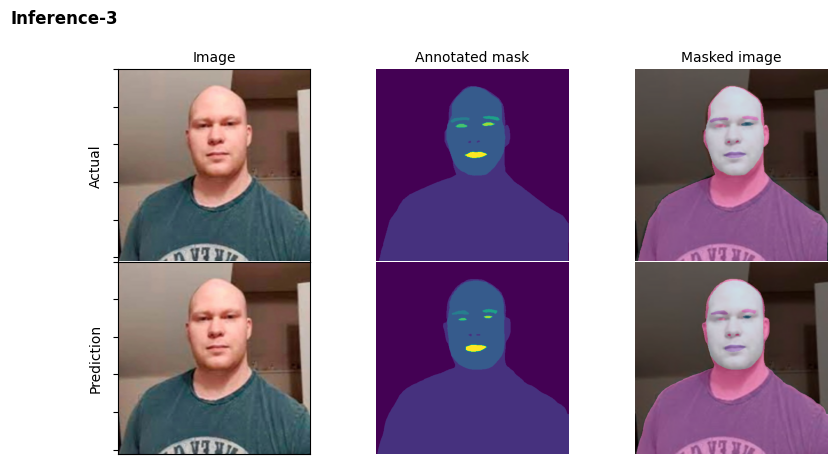

In [9]:
def visualize_prediction_ddr(test_ds_list):
    for i,(image,mask,image_test) in enumerate(test_ds_list):
        pred_mask = torch.argmax(best_model_ddr(image.unsqueeze(0).cuda()), 1).squeeze(0).cpu().numpy()
        visualize_seg_mask([(image_test,mask.cpu().numpy()),(image_test,pred_mask)],f'Inference-{i+1}', ['Actual','Prediction'])

individual_test_dataset = EasyPortraitDataset(os.path.join(data_dir, 'images/test'), os.path.join(data_dir, 'annotations/test'),test_transform, manual_test=True)
visualize_prediction_ddr([individual_test_dataset[i] for i in range(3)])

### Model 2: SegFormer

We want to try SegFormer-B2 variant, which require us to use lower batch size due to limited GPU memory<br>
Therefore, we need to reinstantiate our data loader objects and reconfigure the settings

In [10]:
# Data Loader
batch_size = 8 
train_dataloader = dataloaders.get(dataset=train_dataset, dataloader_params={"num_workers": 2, "batch_size": batch_size, "shuffle": True, "worker_init_fn": seed_worker})
valid_dataloader = dataloaders.get(dataset=valid_dataset, dataloader_params={"num_workers": 2, "batch_size": batch_size, "shuffle": False, "worker_init_fn": seed_worker})
test_dataloader = dataloaders.get(dataset=test_dataset, dataloader_params={"num_workers": 2, "batch_size": batch_size, "shuffle": False, "worker_init_fn": seed_worker})

#### Train Model

In [11]:
# Define Model with Transfer Learning
model_sef = models.get(
    model_name=Models.SEGFORMER_B2,
    arch_params={"use_aux_heads": False},
    num_classes=9,                          
    pretrained_weights="cityscapes"         
)

# Define Train Params
train_params_sef = {"max_epochs": 2,
                "initial_lr": 1e-4,
                "optimizer": "Adam",
                "loss": "LabelSmoothingCrossEntropyLoss",
                "metric_to_watch": "IoU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [{'IOU':{'num_classes':9}}],
                "valid_metrics_list": [{'IOU':{'num_classes':9}}],
                }

# Training Model
trainer_sef = Trainer("easyportrait-ss-train-exp",ckpt_root_dir='/kaggle/working/')
trainer_sef.train(model=model_sef, training_params=train_params_sef,
              train_loader=train_dataloader, valid_loader=valid_dataloader,)

Downloading: "https://sghub.deci.ai/models/segformer_b2_cityscapes.pth" to /root/.cache/torch/hub/checkpoints/segformer_b2_cityscapes.pth
100%|██████████| 314M/314M [00:07<00:00, 42.5MB/s]
[2023-11-05 18:37:03] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture segformer_b2
[2023-11-05 18:37:03] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231105_183703_112366`
[2023-11-05 18:37:03] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_183703_112366


The console stream is now moved to /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_183703_112366/console_Nov05_18_37_03.txt


[2023-11-05 18:37:04] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            14000      (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1750       (len(train_loader))
    - Gradient updates per epoch:   1750       (len(train_loader) / batch_accumulate)

[2023-11-05 18:37:04] INFO - sg_trainer.py - Started training for 2 epochs (0/1)

Validating: 100%|██████████| 250/250 [01:40<00:00,  2.48it/s]
[2023-11-05 19:44:34] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_183703_112366/ckpt_best.pth
[202

SUMMARY OF EPOCH 0
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.0777
│   └── Iou = 0.6686
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0539
    └── Iou = 0.7929



Validating epoch 1: 100%|██████████| 250/250 [01:25<00:00,  2.92it/s]
[2023-11-05 20:51:48] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_183703_112366/ckpt_best.pth
[2023-11-05 20:51:48] INFO - sg_trainer.py - Best checkpoint overriden: validation IoU: 0.8094602227210999


SUMMARY OF EPOCH 1
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.0567
│   │   ├── Epoch N-1      = 0.0777 (↘ -0.021)
│   │   └── Best until now = 0.0777 (↘ -0.021)
│   └── Iou = 0.7906
│       ├── Epoch N-1      = 0.6686 (↗ 0.122)
│       └── Best until now = 0.6686 (↗ 0.122)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.0512
    │   ├── Epoch N-1      = 0.0539 (↘ -0.0027)
    │   └── Best until now = 0.0539 (↘ -0.0027)
    └── Iou = 0.8095
        ├── Epoch N-1      = 0.7929 (↗ 0.0166)
        └── Best until now = 0.7929 (↗ 0.0166)



[2023-11-05 20:51:49] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|█████████▉| 249/250 [01:23<00:00,  3.36it/s]

#### Evaluate Model

In [12]:
best_model_sef = models.get(
    model_name=Models.SEGFORMER_B2,
    arch_params={"use_aux_heads": False},
    num_classes=9,         
    checkpoint_path=os.path.join(trainer_sef.checkpoints_dir_path,'ckpt_best.pth')
)

best_model_sef.eval()
trainer_sef.test(model=best_model_sef, test_loader=test_dataloader)

[2023-11-05 20:53:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/easyportrait-ss-train-exp/RUN_20231105_183703_112366/ckpt_best.pth checkpoint.
Testing: 100%|█████████▉| 499/500 [03:12<00:00,  2.46it/s]

{'LabelSmoothingCrossEntropyLoss': 0.058101684, 'IoU': 0.7496606111526489}

#### Individual Testing

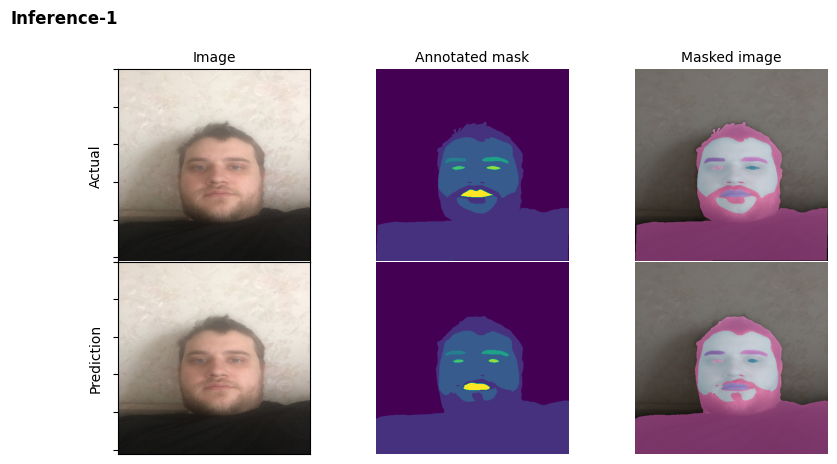

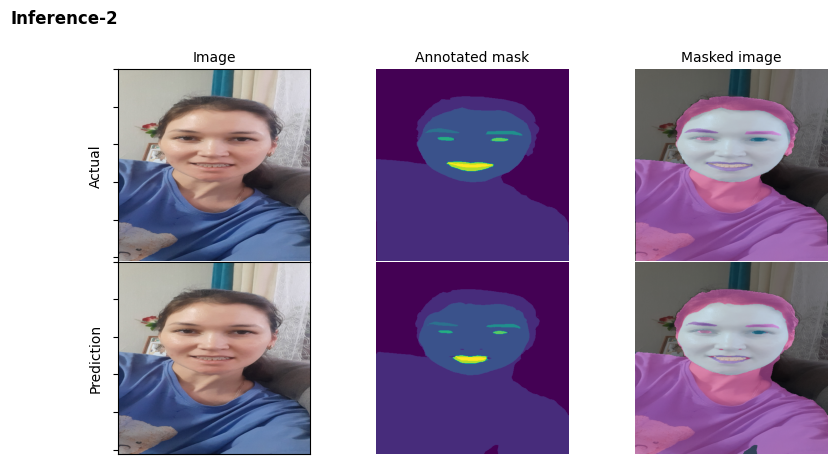

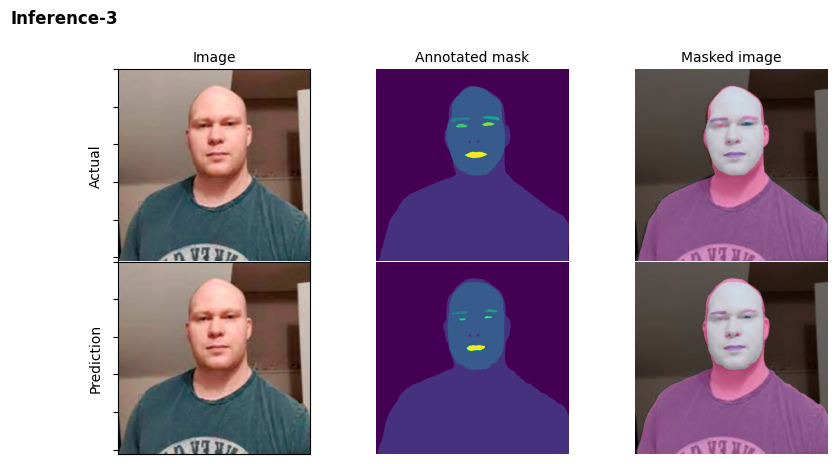

In [13]:
def visualize_prediction_sef(test_ds_list):
    for i,(image,mask,image_test) in enumerate(test_ds_list):
        pred_mask = torch.argmax(best_model_sef(image.unsqueeze(0).cuda()), 1).squeeze(0).cpu().numpy()
        visualize_seg_mask([(image_test,mask.cpu().numpy()),(image_test,pred_mask)],f'Inference-{i+1}', ['Actual','Prediction'])

individual_test_dataset = EasyPortraitDataset(os.path.join(data_dir, 'images/test'), os.path.join(data_dir, 'annotations/test'),test_transform, manual_test=True)
visualize_prediction_sef([individual_test_dataset[i] for i in range(3)])